<a href="https://colab.research.google.com/github/victormurcia/CTS_Test/blob/main/CTS_Unifying_Routines_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#I need to import locale to ensure that the encoding is set to UTF-8 (weird Google Colab bug)
import locale
locale.getpreferredencoding = lambda: "UTF-8"

#Check the current build in Google Colab
!cat /etc/*release
print('\n')

#Check CUDA version
!nvcc --version
print('\n')

#Ensure that the required packages are installed in the current environment
install_pckgs = True
if install_pckgs == True:
  #General functionalities
  #!pip install numpy --quiet
  #!pip install pandas --quiet
  #!pip install seaborn --quiet
  #!pip install matplotlib --quiet
  !pip install "dask[complete]" --quiet
  !pip install ipywidgets --quiet

  #NLP Packages
  !pip install spacy==3.4.4 --quiet
  !pip install scispacy --quiet
  !pip install negspacy --quiet
  !pip install nltk

  #Medspacy Stuff (Including QuickUMLS Installation)
#  !pip install medspacy --quiet
#  !conda install -c conda-forge -q -y libiconv
#  !pip install -q unidecode
#  !pip install unqlite>=0.8.1
#  !pip install medspacy_simstring>=2.1
#  !pip install --no-deps medspacy_quickumls==2.6
#  !pip install leveldb

  #Stuff for Transformer models
  !pip install transformers
#  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet
  print('\n')

#Spacy models used for processing biomedical, scientific, or clinical text
#Spacy pipeline for biomedical data.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz --quiet
#Spacy pipeline for biomedical data. Has a larger vocabulary and 50k word vectors
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz --quiet
#This one is another spacy pipeline with 785k vocabulary and uses scibert-base as a transformer model
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_scibert-0.5.1.tar.gz --quiet
#Spacy pipeline for biomedical data with 600k word vectors
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_lg-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the CRAFT corpus.
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_craft_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the JNLPBA corpus.
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_jnlpba_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the BC5CDR corpus.
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the BIONLP13CG corpus.
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz --quiet
#This is the med7 transformer model found here: https://github.com/kormilitzin/med7
#!pip install https://huggingface.co/kormilitzin/en_core_med7_trf/resolve/main/en_core_med7_trf-any-py3-none-any.whl --quiet
#This is the med7 vector model
#!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl --quiet

In [2]:
#Import the required libraries/packages
#General utilities
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random, time,sys, re,datetime,requests
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from tqdm import tqdm
import urllib.error
from ast import literal_eval
import ast

#NLP Stuff
#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS #Load stopwords
from spacy.language import Language
from spacy.tokenizer import Tokenizer
#Scispacy
import scispacy
from scispacy.linking import EntityLinker
from scispacy.abbreviation import AbbreviationDetector
from scispacy.hyponym_detector import HyponymDetector
#Medspacy
#import medspacy
#from medspacy.ner import TargetRule
#from medspacy.visualization import visualize_ent
#from quickumls.constants import MEDSPACY_DEFAULT_SPAN_GROUP_NAME
#import quickumls.spacy_component
#from medspacy.util import get_quickumls_demo_dir
#from medspacy.util import DEFAULT_PIPE_NAMES
#from medspacy.visualization import visualize_ent
#from medspacy.section_detection import Sectionizer

from negspacy.negation import Negex

#To use Transformers models from HuggingFace
import transformers
from transformers import AutoTokenizer, AutoModel,AutoModelForTokenClassification

#Enable data to be extracted from my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Data

In [10]:
#Load Patient Dataframe
url = 'https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/100_veteran_df.csv'
patients_df = pd.read_csv(url)

#Load the inclusion criteria
url ='https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/parsed_ct_ic.csv'
parsed_ct_ic = pd.read_csv(url)

#Load the exclusion criteria
url ='https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/parsed_ct_ec.csv'
parsed_ct_ec = pd.read_csv(url)

In [11]:
patients_df.columns

Index(['Unnamed: 0', 'CODE_als', 'DESCRIPTION_als', 'Id_cps', 'CODE_cps',
       'DESCRIPTION_cps', 'REASONCODE_cps', 'REASONDESCRIPTION_cps',
       'CODE_cds', 'DESCRIPTION_cds', 'CODE_dvs', 'DESCRIPTION_dvs', 'UDI_dvs',
       'Id_iss', 'BODYSITE_CODE_iss', 'BODYSITE_DESCRIPTION_iss',
       'MODALITY_CODE_iss', 'MODALITY_DESCRIPTION_iss', 'SOP_CODE_iss',
       'SOP_DESCRIPTION_iss', 'CODE_ims', 'DESCRIPTION_ims', 'CODE_mds',
       'DESCRIPTION_mds', 'DISPENSES_mds', 'TOTALCOST_mds', 'REASONCODE_mds',
       'REASONDESCRIPTION_mds', 'CODE_obs', 'DESCRIPTION_obs', 'VALUE_obs',
       'UNITS_obs', 'Id_pts', 'BIRTHDATE_pts', 'PREFIX_pts', 'MARITAL_pts',
       'RACE_pts', 'ETHNICITY_pts', 'GENDER_pts', 'BIRTHPLACE_pts', 'CITY_pts',
       'STATE_pts', 'COUNTY_pts', 'ZIP_pts', 'LAT_pts', 'LON_pts',
       'HEALTHCARE_EXPENSES_pts', 'HEALTHCARE_COVERAGE_pts', 'CODE_prs',
       'DESCRIPTION_prs', 'REASONCODE_prs', 'REASONDESCRIPTION_prs',
       'CODE_sps', 'DESCRIPTION_sps'],
      dt

# Routines/Functions

In [ ]:
#Order of operations
# 1. Load the patients dataframe
# 2. Extract the EHR for the current patient
# 3. Preprocess each patient feature column
# 4. Run the NER model on each patient feature
# 5. Run a query on clinicaltrials.gov for all the conditions present in the patient profile
# 6. Extract the eligibility criteria for each queried clinical trial for each condition
# 7. Split eligibility criteria into inclusion/exclusion sections
# 8. Run NER model on both inclusion/exclusion sections
# 9. Determine Sorensen-Dice index between inclusion/exclusion sections and the patient EHR
# 10. Return the complete list of clinical trials stating whether the patient would qualify or not for each clinical trial

In [27]:
# define a function to convert age strings to years
def convert_age(age_str):
    if pd.isna(age_str):
        return None
    age_components = age_str.split()
    if len(age_components) == 2 and (age_components[1] == 'Years' or age_components[1] == 'Year'):
        return int(age_components[0])
    elif len(age_components) == 2 and (age_components[1] == 'Months' or age_components[1] == 'Month'):
        return int(age_str.split()[0])/12
    elif len(age_components) == 4 and age_components[3] == 'Months':
        return int(age_components)/12
    else:
        return None
########################################################################################################
def str_to_list(s):
  """
  Convert a string representation of a list to a Python list.

  Args:
  s (str): A string representation of a list.

  Returns:
  list: The list represented by the input string.

  Raises:
  SyntaxError: If the input string is not a valid Python list.
  """
  # Replace 'nan' with 'None' for compatibility with ast.literal_eval
  s = s.replace("nan", "None")
  return ast.literal_eval(s)

########################################################################################################
def list_to_string(lst,mode):
  """
  Convert a list to a string using the specified mode.

  Args:
  lst (list): A list to convert to a string.
  mode (int): The mode to use for converting the list to a string. Must be 1 or 2.

  Returns:
  str: The list converted to a string using the specified mode. If the mode is invalid,
        returns 0.

  Raises:
  ValueError: If the mode is not 1 or 2.
  """
  if mode == 1:
    return ' '.join([str(i) if i is not None else 'None' for i in lst])
  elif mode == 2:
    return ''.join([str(i) if i is not None else 'None' for i in lst])
  else:
    print('Invalid Mode')
    return 0

########################################################################################################
def expand_list_to_df(final_patient_df,list_of_aspects,prefs):
  """
  Convert a list of aspects and corresponding prefixes into a Pandas DataFrame.

    Args:
        list_of_aspects (list): A list of aspects for each patient.
        prefs (list): A list of prefixes for each condition to be used for naming.

    Returns:
        pandas.DataFrame: A DataFrame containing the aspects and corresponding conditions
            for all patients.
    """
  df_list = []
  for i in range(len(list_of_aspects)):
    c_aspect = list(set(final_patient_df['Patient_Profile'][i]))
    pref = prefs[i]
    n_aspects = len(c_aspect)
    aspect_count = [pref + str(i) for i,x in enumerate(c_aspect)]
    aspect_dict = zip(aspect_count,c_aspect)
    aspect_df = pd.DataFrame(aspect_dict,columns=['aspects', 'Patient_Profile'])
    df_list.append(aspect_df)

  #Create dataframe from list of dataframes
  result = pd.concat(df_list).reset_index(drop=True)

  return result
########################################################################################################
def create_patient_df_for_NER(patients_df,patient_num):
  """
  This function creates a dataframe for a single patient from the
  """
  #Select a single row from the DataFrame
  row_data = patients_df.loc[patient_num]

  #Create a new DataFrame with the single row
  patient_df = pd.DataFrame([row_data], columns=row_data.index)

  #Select columns that summarize patient profile and put them into a list
  allergies     = patient_df['DESCRIPTION_als'].apply(str_to_list)
  condition     = patient_df['DESCRIPTION_cds'].apply(str_to_list)
  devices       = patient_df['DESCRIPTION_dvs'].apply(str_to_list)
  immunizations = patient_df['DESCRIPTION_ims'].apply(str_to_list)
  medications   = patient_df['DESCRIPTION_mds'].apply(str_to_list)
  procedures    = patient_df['DESCRIPTION_prs'].apply(str_to_list)
  birthday      = patient_df['BIRTHDATE_pts'].apply(str_to_list)
  marital       = patient_df['MARITAL_pts'].apply(str_to_list)
  race          = patient_df['RACE_pts'].apply(str_to_list)
  ethnicity     = patient_df['ETHNICITY_pts'].apply(str_to_list)
  gender        = patient_df['GENDER_pts'].apply(str_to_list)
  city          = patient_df['CITY_pts'].apply(str_to_list)
  county        = patient_df['COUNTY_pts'].apply(str_to_list)

  ######################################################################################################
  #The data from the observation.csv files contain simulated unstructured data and requires different handling than the other elements.
  #1. Combine the observations, values, and units into a dictionary. Use observations as key. The most recent observation will be used.
  observations  = ast.literal_eval(patient_df['DESCRIPTION_obs'][patient_num].replace("nan", "None"))
  values        = ast.literal_eval(patient_df['VALUE_obs'][patient_num].replace("nan", "None"))
  units         = ast.literal_eval(patient_df['UNITS_obs'][patient_num].replace("nan", "None"))

  #Combine the observations, values, and units into a dictionary. Use observations as key. The most recent observation will be used to define the patient.
  result_dict = dict(zip(observations, zip(values, units)))
  temp_df = pd.DataFrame.from_dict(result_dict).fillna('')
  new_row = temp_df.apply(lambda x: ' '.join(x), axis=0)
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
  obs_df['aspects'] = temp_df.columns
  obs_df = obs_df.reindex(columns=['aspects', 'Patient_Profile']).reset_index(drop=True)
  ######################################################################################################

  #Make list for patient profile
  patient_prof_list = [allergies, condition, devices, immunizations, medications, procedures, birthday, marital, race, ethnicity, gender, city, county]
  patient_prof_cols = ['allergies', 'condition', 'devices', 'immunizations', 'medications', 'procedures', 'birthday',
                       'marital', 'race', 'ethnicity', 'gender', 'city', 'county']

  #Create a dictionary with column names and Series data
  data_dict = dict(zip(patient_prof_cols, patient_prof_list))

  #Create a new DataFrame with the single column
  patient_prof = pd.DataFrame(data_dict)

  #Concatenate the Series data into a single Series
  combined_series = pd.concat(patient_prof_list)

  #Create a DataFrame with a single column using the combined Series
  final_patient_df = pd.DataFrame({'Patient_Profile': combined_series})

  #Get column names of patient df
  final_patient_df['aspects'] = patient_prof_cols

  #Change the order of columns,reset the index, and drop the index column
  final_patient_df = final_patient_df.reindex(columns=['aspects', 'Patient_Profile']).reset_index().drop('index',axis=1)

  #Concatenate the oberservation df and the rest of the patient profile
  final_patient_df = pd.concat([final_patient_df, obs_df]).reset_index(drop=True)

  #Expand the categories of patient aspects so that every reading is in its own row instead of having a list
  list_of_aspects = final_patient_df['Patient_Profile'][0:5]
  prefs = ['allergy_', 'condition_','device_','immunization_','meds_','procedures_']
  result = expand_list_to_df(final_patient_df,list_of_aspects,prefs)
  final_patient_profile_df = pd.concat([final_patient_df,result]).reset_index(drop=True)
  final_patient_profile_df = final_patient_profile_df.drop(final_patient_profile_df.index[0:6]).reset_index(drop=True)

  #Convert the list column to a string column separated by a single space
  final_patient_profile_df['Patient_Profile'][:7] = final_patient_profile_df['Patient_Profile'][:7].apply(list_to_string, args = (1,))#.apply(lambda x: ' '.join(map(str, eval(x))))

  #Create new column that combines the aspects and Patient_Profile columns into a single column to be parsed
  final_patient_profile_df['text_to_parse'] = final_patient_profile_df['aspects'] + ' is ' + final_patient_profile_df['Patient_Profile']

  return final_patient_profile_df
########################################################################################################
def get_umls_codes(text, model, suffix, semantic_type_map):
  """
  Extracts UMLS codes, labels, and semantic mappings from a given text using a pre-trained spaCy model.

  Args:
  - text: input text to extract UMLS codes and labels from
  - model: pre-trained spaCy model to use for NLP tasks
  - suffix: a string to append to the keys in the output dictionary
  - semantic_type_map: a dictionary mapping UMLS semantic types to human-readable labels

  Returns:
  - list of dictionaries containing UMLS code information, labels, and semantic mappings for each entity in the text
  """
  # Process the text and extract UMLS codes
  doc = model(text)
  umls_codes = []

  for entity in doc.ents:
    for umls_ent in entity._.kb_ents:
      umls_id = umls_ent[0]
      umls_entity = model.get_pipe("scispacy_linker").kb.cui_to_entity[umls_id]
      semantic_type = umls_entity.types[0]
      mapped_type = semantic_type_map.get(semantic_type, "Unknown")

      umls_codes.append({
        "text" + suffix: entity.text,
        "umls_id" + suffix: umls_id,
        "score" + suffix: umls_ent[1],
        "label" + suffix: entity.label_,
        "semantic_mapping" + suffix: mapped_type
      })

  return umls_codes
########################################################################################################
def extract_values(dicts, key):
  """
  Extract a list of values corresponding to the specified key from a list of dictionaries.

    Args:
        dicts (list): A list of dictionaries.
        key (str): The key to extract values for.

    Returns:
        list: A list of values corresponding to the specified key. If the key is not present in a
              dictionary, None is returned for that dictionary.
    """
  return [d.get(key, None) for d in dicts]
########################################################################################################
def run_ner(df,col_name,model,semantic_type_map):
  """
  Extracts UMLS codes from text data in a given DataFrame column using a pre-trained spaCy model.

  Args:
  - df: pandas DataFrame containing the text data
  - col_name: string representing the name of the column in df that contains the text data
  - model: pre-trained spaCy model to use for NLP tasks

  Returns:
  - pandas DataFrame with new columns for each UMLS code extracted from the text data
  """

  if col_name == 'text_to_parse':#'Patient_Profile':
    ner_results_col = 'umls_codes_patient'
    suffix = '_pat'
  elif col_name == 'inclusion_criteria':
    ner_results_col = 'umls_codes_ic'
    suffix = '_ic'
  elif col_name == 'exclusion_criteria':
    ner_results_col = 'umls_codes_ec'
    suffix = '_ec'
  else:
    print('Invalid column name')

  #Run the NER model on patient df and get UMLS codes after parsing and entity linking
  df[ner_results_col] = df[col_name].apply(get_umls_codes, args = (model,suffix,semantic_type_map))

  # Create new columns from the keys in the dictionaries within the 'info' column lists
  unique_keys = set().union(*(d.keys() for dicts in df[ner_results_col] for d in dicts))

  #Unpack the dictionary keys into separate columns
  for key in unique_keys:
    df[key] = df[ner_results_col].apply(lambda dicts: extract_values(dicts, key))

  return df
########################################################################################################
def contains_multiple_words(s):
  """
  Check if a string is composed of multiple space-separated words.

  Args:
  s (str): A string to check.

  Returns:
  bool: True if the input string contains multiple space-separated words, False otherwise.
  """
  if len(s.split()) > 1:
    return True
  else:
    return False
########################################################################################################
def filter_list(list1, list2, values):
  """
  Returns a new list made by only returning the elements of list1 based on the values of list2.

  Parameters:
  list1 (list): The list of elements to filter.
  list2 (list): The list of values used for filtering.
  values (list): A list of values to filter on.

  Returns:
  list: A new list that contains only the elements of list1 where list2 is equal to any of the values in the values list.
  """
  new_list = [list1[i] for i in range(len(list2)) if list2[i] in values]
  return new_list
########################################################################################################
def get_list_of_conditions_from_patient_df(patient_ner_df,semantic_type_map):
  """
  """
  #Make lists of conditions and their semantic counterparts from the parsed patient dataframe
  list2 = patient_ner_df['semantic_mapping_pat'].explode().tolist()
  list1 = patient_ner_df['text_pat'].explode().tolist()

  #Return list of conditions that have been labeled with one of the terms below

  #Get all the values as a list
  #labels =  list(semantic_type_map.values())#['Antibiotic','Clinical_Drug','Disease','Drug']
  semantic_type_map = {
    "T190": "Anatomical_Abnormality",
    "T195": "Antibiotic",
    "T007": "Bacterium",
    "T053": "Behavior",
    "T103": "Chemical",
    "T200": "Clinical_Drug",
    "T060": "Diagnostic_Procedure",
    "T047": "Disease",
    "T121": "Drug",
    "T126": "Enzyme",
    "T004": "Fungus",
    "T028": "Gene",
    "T131": "Hazardous_Substance",
    "T125": "Hormone",
    "T129": "Immunologic_Factor",
    "T197": "Inorganic_Chemical",
    "T037": "Injury",
    "T074": "Medical Device",
    "T048": "Mental_Dysfunction",
    "T109": "Organic_Chemical",
    "T001": "Organism",
    "T067": "Phenomenon",
    "T121": "Pharmacologic_Substance",
    "T167": "Substance",
    "T184": "Symptom",
    "T005": "Virus",
    "T127": "Vitamin"
    }
  labels =  list(semantic_type_map.values())#['Antibiotic','Clinical_Drug','Disease','Drug']
  #labels =  ['Antibiotic','Clinical_Drug','Disease','Drug']
  filtered_list = filter_list(list1, list2, labels)

  #Get list of conditions from parsed patient dataframe and remove duplicates
  list_of_conditions = list(set(filtered_list))

  # Remove nan values from the list using list comprehension and sort elements in alphabetical order
  list_of_conditions = sorted([x for x in list_of_conditions if not pd.isna(x)])

  # Define a regular expression pattern to match brackets and parentheses
  pattern = r"[\[\]\(\)]"

  # Remove brackets and parentheses from each element in the list
  list_of_conditions = [re.sub(pattern, "", str(elem)) for elem in list_of_conditions]

  return list_of_conditions
########################################################################################################
def get_clinical_trials(condition):
  """
  Creates a pandas dataframe from a query to clinicaltrials.gov

  Args:
  - condition: string representing the condition to search for

  Returns:
  - pandas dataframe with clinical trial data
  """
  #Check that condition is only 1 word else concatenate the string with a + sign
  multiword_condition = contains_multiple_words(condition)
  if multiword_condition == True:
    condition = "+".join(condition.split())
  #print(condition)
  a = 'https://clinicaltrials.gov/api/query/study_fields?expr='
  b = '&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CMinimumAge%2CMaximumAge%2CGender%2CStudyPopulation%2CEligibilityCriteria'
  c = '&min_rnk=1&max_rnk=1000&fmt=csv'
  q=(a + condition + b + c)
  #print(q)
  #qtrials_df = pd.read_csv(q,skiprows=10)
  # Read CSV data from URL and handle errors
  for i in range(5):
    try:
      qtrials_df = pd.read_csv(q, skiprows=10)
      break
    except urllib.error.URLError as e:
      print("URLError:", e.reason)
      print("Retrying in 5 seconds...")
      time.sleep(5)
    except urllib.error.HTTPError as e:
      if e.code == 500:
        print(condition,"HTTP Error 500: Internal Server Error")
      else:
        print("HTTP Error:", e.code)
      break
  else:
    raise ValueError("Unable to connect to the server after 5 attempts")
  return qtrials_df
########################################################################################################
#PART 4. Query for clinical trials based on patient conditions
def query_trials_wrapper(list_of_conditions):
  """
  """
  list_of_cts = []
  for condition in list_of_conditions:
    #print(condition)
    qtrials_df = get_clinical_trials(condition)
    list_of_cts.append(qtrials_df)

  # Concatenate all DataFrames in the list into a single DataFrame
  all_trials_df = pd.concat(list_of_cts, ignore_index=True)

  return all_trials_df
########################################################################################################
def split_criteria(eligibility_criteria):
    # Split the input string
    substrings = eligibility_criteria.split('||')
    # Initialize the inclusion and exclusion criteria sections
    inclusion_criteria = ''
    exclusion_criteria = ''

    # Loop through the substrings to build the inclusion and exclusion criteria sections
    for i in range(len(substrings)):
        if 'Key Inclusion Criteria:' in substrings[i] or 'Inclusion Criteria:' in substrings[i]:
            if i+1 < len(substrings):
                inclusion_criteria += substrings[i+1]
        elif 'Key Exclusion Criteria:' in substrings[i] or 'Exclusion Criteria:' in substrings[i]:
            if i+1 < len(substrings):
                exclusion_criteria += substrings[i+1]

    # Return the inclusion and exclusion criteria sections as a tuple
    return pd.Series([inclusion_criteria, exclusion_criteria])
########################################################################################################
def calculate_SDI(patient_ner_df,parsed_trials_df):

  #Remove duplicates from the inclusion and exclusion criteria codes
  parsed_trials_df['umls_id_ic_clean'] = parsed_trials_df['umls_id_ic'].apply(lambda x: list(set(x)))
  parsed_trials_df['umls_id_ec_clean'] = parsed_trials_df['umls_id_ec'].apply(lambda x: list(set(x)))

  #Make list of patient umls codes, remove duplicates and remove NaNs
  patient_codes_list = sorted(list(set([x for x in patient_ner_df['umls_id_pat'].explode().tolist() if not pd.isna(x)])))

  # Compute Sorensen-Dice Index between the list of patient codes and the list of codes of the inclusion criteria for each clinical trial
  parsed_trials_df['SDI'] = parsed_trials_df['umls_id_ic_clean'].apply(lambda x: common_elements_and_sorensen_dice(patient_codes_list, x))

  return parsed_trials_df
########################################################################################################
def sorensen_dice_index(list1, list2) -> float:
    set1 = set(list1)
    set2 = set(list2)
    return 2 * len(set1.intersection(set2)) / (len(set1) + len(set2))
########################################################################################################
def common_elements_and_sorensen_dice(list1, list2):
  """
  This function finds the common elements between two lists and places these common elements into a new list.
  Then, the sorensen-dice index between this new list and list1 is calculated.

  """
  # Find the common elements between the two lists
  common = list(set(list1).intersection(list2))

  # Calculate the Sorensen-Dice index
  dice_index = 2 * len(common) / (len(list1) + len(common))

  # Return the new list, its length, and the Sorensen-Dice index
  return dice_index
########################################################################################################
def cts_parser(patients_df,model,patient_num):
  """
  This function parses the electronic health records for a patient extracted from the Synthetic Veteran Suicide Dataset and a set of
  Clinical Trials queried using the clinicaltrials.gov API to determine how good of a match a patient is to a clinical trial.
  """
  #Start timer
  start_time = time.time()

  #PART 1. Create and prepare single patient dataframe for NER
  print('Step 1/9 : Creating dataframe for patient')
  final_patient_df = create_patient_df_for_NER(patients_df,patient_num)

  #PART 2. Run the NER model on the patient EHR
  print('Step 2/9 : Run NER on patient data')

  # Define the semantic_type_map
  semantic_type_map = {
    "T116": "Protein",
    "T052": "Activity",
    "T100": "Age_Group",
    "T190": "Anatomical_Abnormality",
    "T017": "Anatomical_Structure",
    "T195": "Antibiotic",
    "T007": "Bacterium",
    "T031": "Body_Substance",
    "T053": "Behavior",
    "T029": "Body_Location",
    "T023": "Body_Part",
    "T103": "Chemical",
    "T200": "Clinical_Drug",
    "T060": "Diagnostic_Procedure",
    "T056": "Recreational_Activity",
    "T047": "Disease",
    "T121": "Drug",
    "T126": "Enzyme",
    "T099": "Family_Group",
    "T004": "Fungus",
    "T028": "Gene",
    "T096": "Group",
    "T131": "Hazardous_Substance",
    "T125": "Hormone",
    "T129": "Immunologic_Factor",
    "T197": "Inorganic_Chemical",
    "T037": "Injury",
    "T130": "Indicator",
    "T034": "Laboratory_Result",
    "T074": "Medical Device",
    "T048": "Mental_Dysfunction",
    "T109": "Organic_Chemical",
    "T001": "Organism",
    "T042": "Organ Function",
    "T067": "Phenomenon",
    "T121": "Pharmacologic_Substance",
    "T101": "Patient_Group",
    "T098": "Population_Group",
    "T081": "Quantitative_Concept",
    "T080": "Qualitative Concept",
    "T089": "Regulation",
    "T167": "Substance",
    "T054": "Social_Behavior",
    "T184": "Symptom",
    "T079": "Temporal Concept",
    "T005": "Virus",
    "T127": "Vitamin"
    }
  patient_ner_df = run_ner(final_patient_df, 'text_to_parse', model, semantic_type_map)

  #PART 3. Get list of patient conditions after parsing EHR while also removing duplicates
  print('Step 3/9 : Creating list of patient conditions ')
  list_of_conditions = get_list_of_conditions_from_patient_df(patient_ner_df,semantic_type_map)
  print('Found ', len(list_of_conditions),' unique conditions on patient EHR')
  print(list_of_conditions)

  #PART 4. Query for clinical trials based on patient conditions and generate CT dataframe
  print('Step 4/9 : Querying for clinical trials')
  all_trials_df = query_trials_wrapper(list_of_conditions)

  #PART 5. Filter dataframe containing only clinical trials that are actively recruiting, match the patient gender and age prior to parsing
  print('Step 5/9 : Only include clinical trials that are actively recruiting')
  #Specify the gender of the patient
  patient_gender = patient_ner_df.loc[patient_ner_df['aspects'] == 'gender', 'Patient_Profile'].values[0]
  if patient_gender == 'M':
    patient_gender = 'Male'
  elif patient_gender == 'F':
    patient_gender = 'Female'

  #Determine patient age
  patient_bday = patient_ner_df.loc[patient_ner_df['aspects'] == 'birthday', 'Patient_Profile'].values[0]
  birth_date = datetime.datetime.strptime(patient_bday, '%Y-%m-%d').date()
  today = datetime.date.today()
  patient_age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))

  #Filter by Recruiting status
  recruiting_trials_df = all_trials_df[all_trials_df['OverallStatus']=='Recruiting'].reset_index()

  #Filter by gender inclusivity
  gender_mask = (recruiting_trials_df['Gender'] == patient_gender) | (recruiting_trials_df['Gender'] == 'All')
  recruiting_trials_df = recruiting_trials_df[gender_mask].reset_index()

  # apply the function to the 'age' column
  recruiting_trials_df['MinimumAge'] = recruiting_trials_df['MinimumAge'].apply(convert_age)
  recruiting_trials_df['MaximumAge'] = recruiting_trials_df['MaximumAge'].apply(convert_age)

  # apply boolean indexing to select clinical trials whose minimum and maximum age encompass the patient age
  recruiting_trials_df = recruiting_trials_df[(recruiting_trials_df['MinimumAge'] <= patient_age) & (recruiting_trials_df['MaximumAge'] >= patient_age)]

  #PART 6. Create inclusion and inclusion criteria columns on dataframe for subsequent parsing
  print('Step 6/9 : Split eligibility criteria into inclusion and exclusion sections')
  recruiting_trials_df[['inclusion_criteria', 'exclusion_criteria']] = recruiting_trials_df['EligibilityCriteria'].astype(str).apply(split_criteria)
  nTrials = recruiting_trials_df.shape[0]
  print('Found ', nTrials, ' for current patient')
  #PART 7-8. Run the NER model on the eligibility criteria from the clinical trial df
  print('Step 7/9 : Run NER on Clinical Trial Inclusion Criteria')
  parsed_trials_df = run_ner(recruiting_trials_df,'inclusion_criteria',model,semantic_type_map)
  print('Step 8/9 : Run NER on Clinical Trial Exclusion Criteria')
  parsed_trials_df = run_ner(parsed_trials_df,'exclusion_criteria',model,semantic_type_map)

  #PART 9. Determine whether parsed patient profile has any criteria that is present on the exclusion criteria list
  print('Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes')
  final_df = calculate_SDI(patient_ner_df,parsed_trials_df)

  #End timer
  print("Parsing patient records took: %.2f seconds" % (time.time() - start_time))

  return final_patient_df,patient_ner_df,recruiting_trials_df,final_df

# Setup the Experiment

In [13]:
#List of available models
models = ["en_core_sci_sm","en_core_sci_md","en_core_sci_lg","en_core_sci_scibert","en_ner_craft_md","en_ner_jnlpba_md","en_ner_bionlp13cg_md","en_ner_bc5cdr_md","en_core_med7_lg"]

#Load the pre-trained spaCy NER model with sci-spaCy
model = spacy.load(models[2])

#Add the Negation pipe to spacy pipeline
if 'negex' not in model.pipe_names:
  model.add_pipe("negex")

#Add the abbreviation pipe to the spacy pipeline.
if 'abbreviation_detector' not in model.pipe_names:
  model.add_pipe("abbreviation_detector")

#Add the EntityLinker pipe to spacy pipeline
if 'scispacy_linker' not in model.pipe_names:
  model.add_pipe("scispacy_linker", config={"linker_name": "umls", "max_entities_per_mention": 1})
#quickumls_file_path = get_quickumls_demo_dir()
#print('quickumls_file_path:')
#print(quickumls_file_path)

#if 'medspacy_quickumls' not in model.pipe_names:
#    model.add_pipe("medspacy_quickumls", config={"threshold": 0.7,
#                                           "result_type": "group",
#                                           # do not constrain to the best match for overlapping
#                                           "best_match": False,
#                                           "quickumls_fp": quickumls_file_path})
#
print(model.pipe_names)

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmp9aw85xxr
Finished download, copying /tmp/tmp9aw85xxr to cache at /root/.scispacy/datasets/2b79923846fb52e62d686f2db846392575c8eb5b732d9d26cd3ca9378c622d40.87bd52d0f0ee055c1e455ef54ba45149d188552f07991b765da256a1b512ca0b.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmpqyq16sd2
Finished download, copying /tmp/tmpqyq16sd2 to cache at /root/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmp1geirlr8
Finished download, copying /tmp/tmp1geirlr8 to cache at /root/.scispacy/da

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/concept_aliases.json not found in cache, downloading to /tmp/tmpe82er4r4
Finished download, copying /tmp/tmpe82er4r4 to cache at /root/.scispacy/datasets/6238f505f56aca33290aab44097f67dd1b88880e3be6d6dcce65e56e9255b7d4.d7f77b1629001b40f1b1bc951f3a890ff2d516fb8fbae3111b236b31b33d6dcf.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/kbs/2023-04-23/umls_2022_ab_cat0129.jsonl not found in cache, downloading to /tmp/tmp807kovz8
Finished download, copying /tmp/tmp807kovz8 to cache at /root/.scispacy/datasets/d5e593bc2d8adeee7754be423cd64f5d331ebf26272074a2575616be55697632.0660f30a60ad00fffd8bbf084a18eb3f462fd192ac5563bf50940fc32a850a3c.umls_2022_ab_cat0129.jsonl
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmpq49913r_
Finished download, copying /tmp/tmpq49913r_ to cache at /root/.scispacy/datasets/21a1012c53

# Run the experiment

## Synthetic Patient 0

In [14]:
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)
final_patient_df,patient_ner_df,recruiting_trials_df,final_df = cts_parser(patients_df,model,0)
patient_ner_df

Step 1/9 : Creating dataframe for patient


<ipython-input-12-296739b1504f>:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})


Step 2/9 : Run NER on patient data


/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 3/9 : Creating list of patient conditions 
Found  48  unique conditions on patient EHR
['Acetaminophen', 'Acute viral pharyngitis', 'Ag', 'Amoxicillin', 'BMI', 'Body Mass Index', 'Body mass index', 'COVID-19', 'Cat dander IgE Ab', 'Cholesterol', 'Chronic sinusitis', 'Cladosporium herbarum', 'Clavulanate', 'Concussion', 'Doxycycline Monohydrate', 'Fatigue', 'Fever', 'Fracture', 'Headache', 'Hemoglobin', 'Hep', 'Hep B', 'Hib', 'Hydrochloride 25 MG', 'IPV', 'Influenza virus A', 'Influenza virus B', 'Laceration', 'MCH', 'Naproxen sodium', 'Nausea', 'Otitis media', 'Pain', 'Penicillin V', 'Potassium', 'Sinusitis', 'Streptococcal sore throat', 'Tobacco smoking', 'Triglycerides', 'Viral sinusitis', 'Vomiting symptom', 'Whiplash injury', 'allergic rhinitis', 'diphenhydrAMINE', 'disorder', 'finding', 'mould', 'obesity']
Step 4/9 : Querying for clinical trials
Step 5/9 : Only include clinical trials that are actively recruiting
Step 6/9 : Split eligibility criteria into inclusion and exclus

/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 8/9 : Run NER on Clinical Trial Exclusion Criteria


/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes
Parsing patient records took: 168.56 seconds


,aspects,Patient_Profile,text_to_parse,umls_codes_patient,score_pat,text_pat,umls_id_pat,semantic_mapping_pat,label_pat
0,birthday,1975-03-24,birthday is 1975-03-24,[],[],[],[],[],[]
1,marital,M,marital is M,"[{'text_pat': 'marital', 'umls_id_pat': 'C0024...",[1.0],[marital],[C0024841],[Unknown],[ENTITY]
2,race,white,race is white,"[{'text_pat': 'race', 'umls_id_pat': 'C1315098...","[0.9999998807907104, 1.0]","[race, white]","[C1315098, C0007457]","[Unknown, Population_Group]","[ENTITY, ENTITY]"
3,ethnicity,nonhispanic,ethnicity is nonhispanic,"[{'text_pat': 'ethnicity', 'umls_id_pat': 'C00...",[0.9999998807907104],[ethnicity],[C0015031],[Population_Group],[ENTITY]
4,gender,M,gender is M,"[{'text_pat': 'gender', 'umls_id_pat': 'C00793...","[1.0, 1.0]","[gender, M]","[C0079399, C0025646]","[Unknown, Protein]","[ENTITY, ENTITY]"
...,...,...,...,...,...,...,...,...,...
90,meds_2,Penicillin V Potassium 250 MG Oral Tablet,meds_2 is Penicillin V Potassium 250 MG Oral T...,"[{'text_pat': 'Penicillin V', 'umls_id_pat': '...","[1.0, 1.0, 1.0, 0.9999999403953552]","[Penicillin V, Potassium, MG, Oral Tablet]","[C0030840, C0032821, C0024467, C0993159]","[Organic_Chemical, Pharmacologic_Substance, Un...","[ENTITY, ENTITY, ENTITY, ENTITY]"
91,meds_3,Doxycycline Monohydrate 50 MG Oral Tablet,meds_3 is Doxycycline Monohydrate 50 MG Oral T...,"[{'text_pat': 'Doxycycline Monohydrate', 'umls...","[0.9999999403953552, 1.0, 0.9999999403953552]","[Doxycycline Monohydrate, MG, Oral Tablet]","[C0700451, C0024467, C0993159]","[Organic_Chemical, Unknown, Unknown]","[ENTITY, ENTITY, ENTITY]"
92,meds_4,Acetaminophen 325 MG Oral Tablet,meds_4 is Acetaminophen 325 MG Oral Tablet,"[{'text_pat': 'Acetaminophen', 'umls_id_pat': ...","[1.0, 1.0, 0.9999999403953552]","[Acetaminophen, MG, Oral Tablet]","[C0000970, C0024467, C0993159]","[Organic_Chemical, Unknown, Unknown]","[ENTITY, ENTITY, ENTITY]"
93,meds_5,Acetaminophen 160 MG Chewable Tablet,meds_5 is Acetaminophen 160 MG Chewable Tablet,"[{'text_pat': 'Acetaminophen', 'umls_id_pat': ...","[1.0, 1.0, 1.0]","[Acetaminophen, MG, Chewable Tablet]","[C0000970, C0024467, C0304290]","[Organic_Chemical, Unknown, Unknown]","[ENTITY, ENTITY, ENTITY]"


In [15]:
final_patient_df

,aspects,Patient_Profile,text_to_parse,umls_codes_patient,score_pat,text_pat,umls_id_pat,semantic_mapping_pat,label_pat
0,birthday,1975-03-24,birthday is 1975-03-24,[],[],[],[],[],[]
1,marital,M,marital is M,"[{'text_pat': 'marital', 'umls_id_pat': 'C0024...",[1.0],[marital],[C0024841],[Unknown],[ENTITY]
2,race,white,race is white,"[{'text_pat': 'race', 'umls_id_pat': 'C1315098...","[0.9999998807907104, 1.0]","[race, white]","[C1315098, C0007457]","[Unknown, Population_Group]","[ENTITY, ENTITY]"
3,ethnicity,nonhispanic,ethnicity is nonhispanic,"[{'text_pat': 'ethnicity', 'umls_id_pat': 'C00...",[0.9999998807907104],[ethnicity],[C0015031],[Population_Group],[ENTITY]
4,gender,M,gender is M,"[{'text_pat': 'gender', 'umls_id_pat': 'C00793...","[1.0, 1.0]","[gender, M]","[C0079399, C0025646]","[Unknown, Protein]","[ENTITY, ENTITY]"
...,...,...,...,...,...,...,...,...,...
90,meds_2,Penicillin V Potassium 250 MG Oral Tablet,meds_2 is Penicillin V Potassium 250 MG Oral T...,"[{'text_pat': 'Penicillin V', 'umls_id_pat': '...","[1.0, 1.0, 1.0, 0.9999999403953552]","[Penicillin V, Potassium, MG, Oral Tablet]","[C0030840, C0032821, C0024467, C0993159]","[Organic_Chemical, Pharmacologic_Substance, Un...","[ENTITY, ENTITY, ENTITY, ENTITY]"
91,meds_3,Doxycycline Monohydrate 50 MG Oral Tablet,meds_3 is Doxycycline Monohydrate 50 MG Oral T...,"[{'text_pat': 'Doxycycline Monohydrate', 'umls...","[0.9999999403953552, 1.0, 0.9999999403953552]","[Doxycycline Monohydrate, MG, Oral Tablet]","[C0700451, C0024467, C0993159]","[Organic_Chemical, Unknown, Unknown]","[ENTITY, ENTITY, ENTITY]"
92,meds_4,Acetaminophen 325 MG Oral Tablet,meds_4 is Acetaminophen 325 MG Oral Tablet,"[{'text_pat': 'Acetaminophen', 'umls_id_pat': ...","[1.0, 1.0, 0.9999999403953552]","[Acetaminophen, MG, Oral Tablet]","[C0000970, C0024467, C0993159]","[Organic_Chemical, Unknown, Unknown]","[ENTITY, ENTITY, ENTITY]"
93,meds_5,Acetaminophen 160 MG Chewable Tablet,meds_5 is Acetaminophen 160 MG Chewable Tablet,"[{'text_pat': 'Acetaminophen', 'umls_id_pat': ...","[1.0, 1.0, 1.0]","[Acetaminophen, MG, Chewable Tablet]","[C0000970, C0024467, C0304290]","[Organic_Chemical, Unknown, Unknown]","[ENTITY, ENTITY, ENTITY]"


In [16]:
recruiting_trials_df

,level_0,index,Rank,NCTId,BriefTitle,...,score_ec,umls_id_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
7,7,128,129,NCT03365622,Efficacy of IV Acetaminophen Versus Oral Aceta...,...,"[0.9999999403953552, 1.0, 0.7249953150749207, ...","[C0001779, C0439234, C0001795, C0439234, C0032...","[C0006826, C3850136, C0392334, C4050142, C0439...","[C0001779, C0013227, C0023884, C0242402, C0205...",0.014925
8,8,135,136,NCT04882202,Acetaminophen and AKI After Aortic Surgery,...,"[1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, ...","[C0030705, C1561643, C0011945, C0034802, C0000...","[C0205081, C0030705, C0020672, C0877130]","[C0030705, C0034802, C0000970, C0005437, C0011...",0.000000
9,10,149,150,NCT06004687,Effect of Acetaminophen Preemptive Analgesia o...,...,"[1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, ...","[C0019664, C0559546, C0226896, C0018787, C0023...",[C0030705],"[C0023884, C0008976, C0019664, C0242402, C0226...",0.000000
11,12,176,177,NCT05563961,"A Partial Randomized, Single-blind or Open-lab...",...,"[1.0, 1.0, 1.0, 1.0, 0.7759926915168762, 1.0, ...","[C0019664, C0392148, C0085762, C0009830, C5438...","[C0001779, C0001675, C0080105, C0439234, C3898...","[C0439231, C0009830, C0004922, C0700624, C0009...",0.029630
13,14,203,204,NCT05685342,Preemptive and Preventive Acetaminophen/Ibupro...,...,"[0.8029533624649048, 0.7958996891975403, 1.0, ...","[C2346733, C0008902, C0242402, C0002771, C0030...","[C0030705, C2346733, C0078944, C0008902, C0439...","[C0002932, C0003290, C0008902, C0039798, C0019...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3447,3751,32804,917,NCT04106570,Neuromuscular Plasticity in Response to Obesit...,...,"[1.0, 0.9999998807907104, 1.0, 1.0, 0.88713526...","[C0681850, C0199168, C0744961, C0035173, C0332...","[C0001779, C1511481, C0439231, C0005893, C0043...","[C0744961, C0199168, C0332290, C0681850, C0035...",0.029630
3448,3752,32831,944,NCT05631535,Obesity Treatment With a Very Low Energy Diet ...,...,"[1.0, 0.8380339741706848, 0.7027180790901184, ...","[C0679646, C1262477, C0011860, C0020538, C0013...","[C0470187, C0679823, C0205265, C2983605, C0439...","[C0679646, C0016977, C0184661, C0231221, C0006...",0.044118
3449,3753,32842,955,NCT04838678,Sympathetic Transduction in Obesity-associated...,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.9999998807907104, ...","[C0441833, C0392148, C0007222, C0022658, C0262...","[C0001779, C0020538, C0009932, C0011900, C0150...","[C0262926, C0011847, C0007222, C0441833, C0392...",0.014925
3450,3754,32844,957,NCT03854058,Respiratory Muscle Strength in Patients With O...,...,"[1.0, 0.8700385093688965, 0.7000194191932678, ...","[C0012634, C0087153, C0205412, C0180307, C0025...","[C0030705, C0520679, C1511481, C0005893, C0205...","[C0012634, C0180307, C2350432, C1511481, C0221...",0.014925


In [17]:
final_df

,level_0,index,Rank,NCTId,BriefTitle,...,score_ec,umls_id_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
7,7,128,129,NCT03365622,Efficacy of IV Acetaminophen Versus Oral Aceta...,...,"[0.9999999403953552, 1.0, 0.7249953150749207, ...","[C0001779, C0439234, C0001795, C0439234, C0032...","[C0006826, C3850136, C0392334, C4050142, C0439...","[C0001779, C0013227, C0023884, C0242402, C0205...",0.014925
8,8,135,136,NCT04882202,Acetaminophen and AKI After Aortic Surgery,...,"[1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, ...","[C0030705, C1561643, C0011945, C0034802, C0000...","[C0205081, C0030705, C0020672, C0877130]","[C0030705, C0034802, C0000970, C0005437, C0011...",0.000000
9,10,149,150,NCT06004687,Effect of Acetaminophen Preemptive Analgesia o...,...,"[1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, ...","[C0019664, C0559546, C0226896, C0018787, C0023...",[C0030705],"[C0023884, C0008976, C0019664, C0242402, C0226...",0.000000
11,12,176,177,NCT05563961,"A Partial Randomized, Single-blind or Open-lab...",...,"[1.0, 1.0, 1.0, 1.0, 0.7759926915168762, 1.0, ...","[C0019664, C0392148, C0085762, C0009830, C5438...","[C0001779, C0001675, C0080105, C0439234, C3898...","[C0439231, C0009830, C0004922, C0700624, C0009...",0.029630
13,14,203,204,NCT05685342,Preemptive and Preventive Acetaminophen/Ibupro...,...,"[0.8029533624649048, 0.7958996891975403, 1.0, ...","[C2346733, C0008902, C0242402, C0002771, C0030...","[C0030705, C2346733, C0078944, C0008902, C0439...","[C0002932, C0003290, C0008902, C0039798, C0019...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3447,3751,32804,917,NCT04106570,Neuromuscular Plasticity in Response to Obesit...,...,"[1.0, 0.9999998807907104, 1.0, 1.0, 0.88713526...","[C0681850, C0199168, C0744961, C0035173, C0332...","[C0001779, C1511481, C0439231, C0005893, C0043...","[C0744961, C0199168, C0332290, C0681850, C0035...",0.029630
3448,3752,32831,944,NCT05631535,Obesity Treatment With a Very Low Energy Diet ...,...,"[1.0, 0.8380339741706848, 0.7027180790901184, ...","[C0679646, C1262477, C0011860, C0020538, C0013...","[C0470187, C0679823, C0205265, C2983605, C0439...","[C0679646, C0016977, C0184661, C0231221, C0006...",0.044118
3449,3753,32842,955,NCT04838678,Sympathetic Transduction in Obesity-associated...,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.9999998807907104, ...","[C0441833, C0392148, C0007222, C0022658, C0262...","[C0001779, C0020538, C0009932, C0011900, C0150...","[C0262926, C0011847, C0007222, C0441833, C0392...",0.014925
3450,3754,32844,957,NCT03854058,Respiratory Muscle Strength in Patients With O...,...,"[1.0, 0.8700385093688965, 0.7000194191932678, ...","[C0012634, C0087153, C0205412, C0180307, C0025...","[C0030705, C0520679, C1511481, C0005893, C0205...","[C0012634, C0180307, C2350432, C1511481, C0221...",0.014925


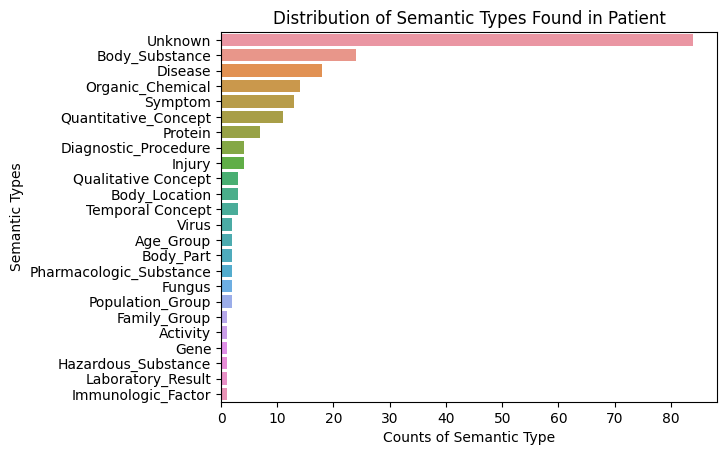

In [18]:
sm_df = patient_ner_df.loc[:,['semantic_mapping_pat']]
exploded = sm_df.explode('semantic_mapping_pat').reset_index()
sns.countplot(y='semantic_mapping_pat', data=exploded,order=exploded['semantic_mapping_pat'].value_counts().index)
plt.xlabel('Counts of Semantic Type')
plt.ylabel('Semantic Types')
plt.title('Distribution of Semantic Types Found in Patient')
plt.show()

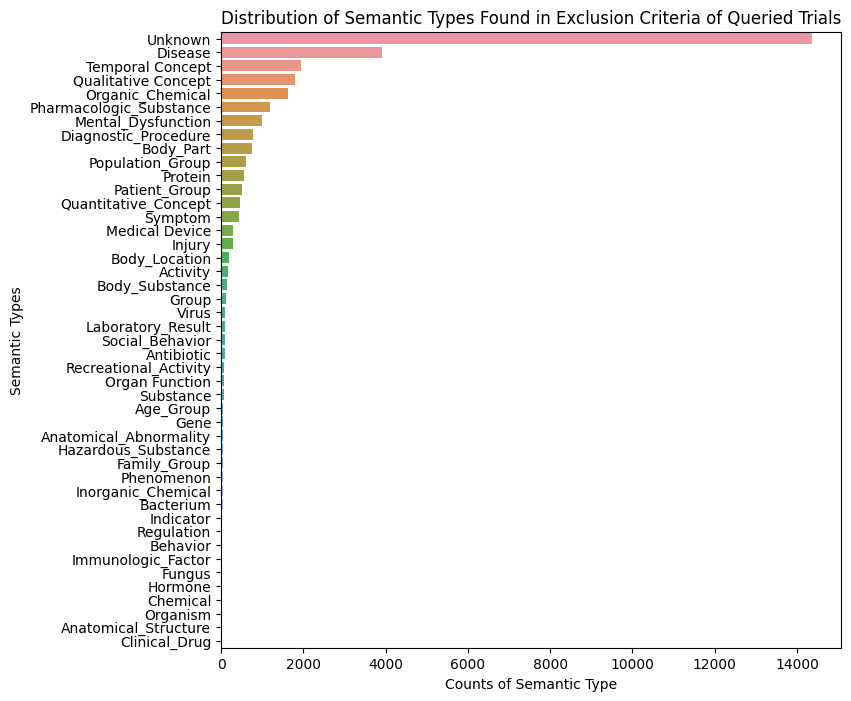

In [19]:
smct_df = final_df.loc[:,['semantic_mapping_ec']]
exploded = smct_df.explode('semantic_mapping_ec').reset_index()
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(y='semantic_mapping_ec', data=exploded,order=exploded['semantic_mapping_ec'].value_counts().index)
plt.xlabel('Counts of Semantic Type')
plt.ylabel('Semantic Types')
plt.title('Distribution of Semantic Types Found in Exclusion Criteria of Queried Trials')
plt.show()

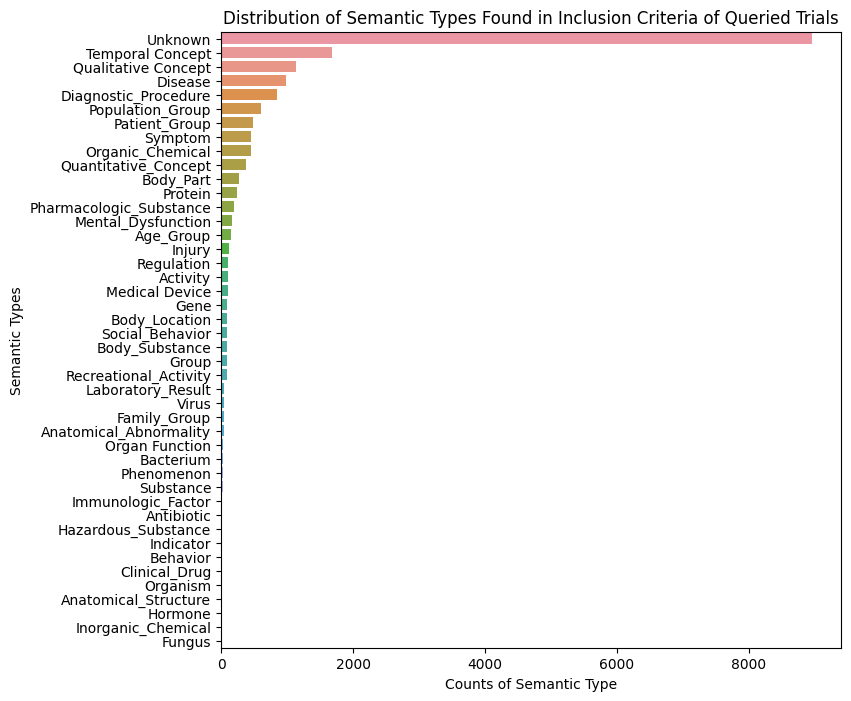

In [20]:
smct_df = final_df.loc[:,['semantic_mapping_ic']]
exploded = smct_df.explode('semantic_mapping_ic').reset_index()
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(y='semantic_mapping_ic', data=exploded,order=exploded['semantic_mapping_ic'].value_counts().index)
plt.xlabel('Counts of Semantic Type')
plt.ylabel('Semantic Types')
plt.title('Distribution of Semantic Types Found in Inclusion Criteria of Queried Trials')
plt.show()

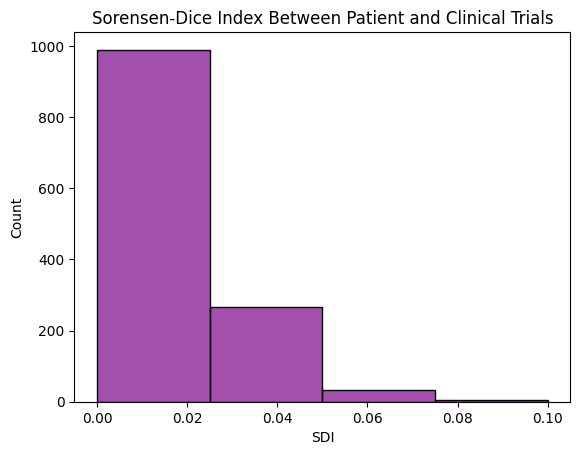

In [25]:
# plot a histogram of the 'age' column using Seaborn
sns.histplot(data=final_df, x='SDI',color='#86148f',bins=4).set_title('Sorensen-Dice Index Between Patient and Clinical Trials')
plt.show()

## Synthetic Patient 10

In [28]:
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)
final_patient_df_10,patient_ner_df_10,recruiting_trials_df_10,final_df_10 = cts_parser(patients_df,model,10)
patient_ner_df_10

Step 1/9 : Creating dataframe for patient
Step 2/9 : Run NER on patient data


<ipython-input-27-5d200deea2e6>:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 3/9 : Creating list of patient conditions 
Found  44  unique conditions on patient EHR
['Acetaminophen', 'Acute allergic reaction', 'Acute bronchitis', 'Ag', 'BMI', 'Body Mass Index', 'Body mass index', 'COVID-19', 'Cat dander IgE Ab', 'Chill', 'Cladosporium herbarum', 'Cough', 'DTaP', 'Epinephrine', 'Fever', 'Fracture', 'HPV', 'Hemoglobin', 'Hep A', 'Hep B', 'Hib', 'IPV', 'Ibuprofen', 'Influenza virus A', 'Influenza virus B', 'Joint pain', 'Laceration', 'Loratadine 5', 'Loss of taste', 'MCH', 'Muscle pain', 'Naproxen sodium', 'Pain', 'Shellfish allergy', 'Sprain of ankle', 'Tdap', 'Tobacco smoking', 'Viral sinusitis', 'disorder', 'finding', 'mould', 'pediatric', 'predniSONE 5 MG', 'varicella']
Step 4/9 : Querying for clinical trials
Step 5/9 : Only include clinical trials that are actively recruiting
Step 6/9 : Split eligibility criteria into inclusion and exclusion sections
Found  1130  for current patient
Step 7/9 : Run NER on Clinical Trial Inclusion Criteria


/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 8/9 : Run NER on Clinical Trial Exclusion Criteria


/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes
Parsing patient records took: 118.21 seconds


,aspects,Patient_Profile,text_to_parse,umls_codes_patient,score_pat,text_pat,umls_id_pat,semantic_mapping_pat,label_pat
0,birthday,1999-03-05,birthday is 1999-03-05,[],[],[],[],[],[]
1,marital,None,marital is None,"[{'text_pat': 'marital', 'umls_id_pat': 'C0024...",[1.0],[marital],[C0024841],[Unknown],[ENTITY]
2,race,asian,race is asian,"[{'text_pat': 'race', 'umls_id_pat': 'C1315098...","[0.9999998807907104, 0.9999999403953552]","[race, asian]","[C1315098, C0003988]","[Unknown, Population_Group]","[ENTITY, ENTITY]"
3,ethnicity,nonhispanic,ethnicity is nonhispanic,"[{'text_pat': 'ethnicity', 'umls_id_pat': 'C00...",[0.9999998807907104],[ethnicity],[C0015031],[Population_Group],[ENTITY]
4,gender,M,gender is M,"[{'text_pat': 'gender', 'umls_id_pat': 'C00793...","[1.0, 1.0]","[gender, M]","[C0079399, C0025646]","[Unknown, Protein]","[ENTITY, ENTITY]"
...,...,...,...,...,...,...,...,...,...
94,meds_2,predniSONE 5 MG Oral Tablet,meds_2 is predniSONE 5 MG Oral Tablet,"[{'text_pat': 'predniSONE 5 MG', 'umls_id_pat'...","[0.9999999403953552, 0.9999999403953552]","[predniSONE 5 MG, Oral Tablet]","[C1533720, C0993159]","[Clinical_Drug, Unknown]","[ENTITY, ENTITY]"
95,meds_3,Naproxen sodium 220 MG Oral Tablet,meds_3 is Naproxen sodium 220 MG Oral Tablet,"[{'text_pat': 'Naproxen sodium', 'umls_id_pat'...","[1.0, 1.0, 0.9999999403953552]","[Naproxen sodium, MG, Oral Tablet]","[C0546873, C0024467, C0993159]","[Organic_Chemical, Unknown, Unknown]","[ENTITY, ENTITY, ENTITY]"
96,meds_4,Ibuprofen 200 MG Oral Tablet,meds_4 is Ibuprofen 200 MG Oral Tablet,"[{'text_pat': 'Ibuprofen', 'umls_id_pat': 'C00...","[1.0, 1.0, 0.9999999403953552]","[Ibuprofen, MG, Oral Tablet]","[C0020740, C0024467, C0993159]","[Organic_Chemical, Unknown, Unknown]","[ENTITY, ENTITY, ENTITY]"
97,meds_5,Acetaminophen 325 MG Oral Tablet,meds_5 is Acetaminophen 325 MG Oral Tablet,"[{'text_pat': 'Acetaminophen', 'umls_id_pat': ...","[1.0, 1.0, 0.9999999403953552]","[Acetaminophen, MG, Oral Tablet]","[C0000970, C0024467, C0993159]","[Organic_Chemical, Unknown, Unknown]","[ENTITY, ENTITY, ENTITY]"


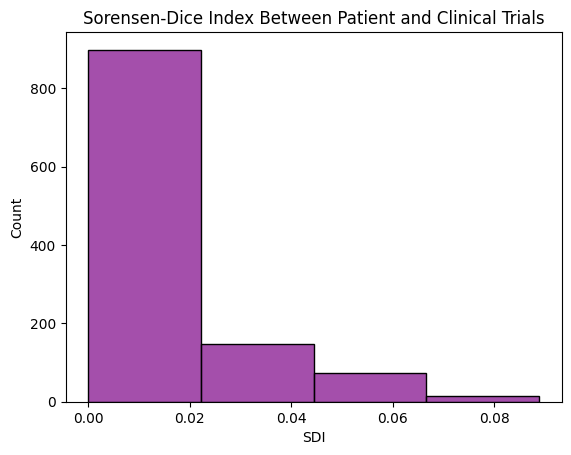

In [29]:
# plot a histogram of the 'age' column using Seaborn
sns.histplot(data=final_df_10, x='SDI',color='#86148f',bins=4).set_title('Sorensen-Dice Index Between Patient and Clinical Trials')
plt.show()

## Synthetic Patient 20

In [33]:
final_patient_df_20,patient_ner_df_20,recruiting_trials_df_20,final_df_20 = cts_parser(patients_df,model,20)
patient_ner_df_20

Step 1/9 : Creating dataframe for patient
Step 2/9 : Run NER on patient data


<ipython-input-27-5d200deea2e6>:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 3/9 : Creating list of patient conditions 
Found  86  unique conditions on patient EHR
['Acetaminophen', 'Acute allergic reaction', 'Acute bacterial sinusitis', 'Acute bronchitis', 'Acute deep venous thrombosis', 'Acute respiratory failure', 'Acute viral pharyngitis', 'Adenovirus', 'Ag', 'Albuterol', 'Amoxicillin', 'Anxiety', 'Appendicitis', 'Aspirin', 'BMI', 'Bicarbonate', 'Body Mass Index', 'Body mass index', 'COVID-19', 'Calcium', 'Childhood asthma', 'Cholesterol', 'Chronic sinusitis', 'Clavulanate', 'Cough', 'Creatinine', 'Dextromethorphan', 'Enoxaparin sodium', 'Fever', 'Fluticasone', 'Fracture subluxation', 'Glucose', 'Hemoglobin', 'Hydrochloride 25 MG', 'Hydrochlorothiazide', 'Hyperlipidemia', 'Hypertension', 'Influenza virus A', 'Ketones', 'Laceration', 'Lactate', 'Loss of taste', 'MCH', 'Naproxen sodium', 'Nitrite', 'Otitis media', 'Oxygen', 'Pain', 'Parainfluenza virus 1', 'Parainfluenza virus 3', 'Penicillin', 'Penicillin G 375 MG/ML Injectable Solution', 'Penicillin V'

/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 8/9 : Run NER on Clinical Trial Exclusion Criteria


/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes
Parsing patient records took: 109.40 seconds


,aspects,Patient_Profile,text_to_parse,umls_codes_patient,score_pat,text_pat,umls_id_pat,semantic_mapping_pat,label_pat
0,birthday,1945-11-15,birthday is 1945-11-15,[],[],[],[],[],[]
1,marital,M,marital is M,"[{'text_pat': 'marital', 'umls_id_pat': 'C0024...",[1.0],[marital],[C0024841],[Unknown],[ENTITY]
2,race,white,race is white,"[{'text_pat': 'race', 'umls_id_pat': 'C1315098...","[0.9999998807907104, 1.0]","[race, white]","[C1315098, C0007457]","[Unknown, Population_Group]","[ENTITY, ENTITY]"
3,ethnicity,hispanic,ethnicity is hispanic,"[{'text_pat': 'ethnicity', 'umls_id_pat': 'C00...","[0.9999998807907104, 1.0]","[ethnicity, hispanic]","[C0015031, C0086409]","[Population_Group, Population_Group]","[ENTITY, ENTITY]"
4,gender,M,gender is M,"[{'text_pat': 'gender', 'umls_id_pat': 'C00793...","[1.0, 1.0]","[gender, M]","[C0079399, C0025646]","[Unknown, Protein]","[ENTITY, ENTITY]"
...,...,...,...,...,...,...,...,...,...
182,meds_15,Amoxicillin 250 MG / Clavulanate 125 MG Oral T...,meds_15 is Amoxicillin 250 MG / Clavulanate 12...,"[{'text_pat': 'Amoxicillin', 'umls_id_pat': 'C...","[1.0, 1.0, 1.0, 1.0, 0.9999999403953552]","[Amoxicillin, MG, Clavulanate, MG, Oral Tablet]","[C0002645, C0024467, C0110038, C0024467, C0993...","[Organic_Chemical, Unknown, Organic_Chemical, ...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY]"
183,meds_16,120 ACTUAT Fluticasone propionate 0.044 MG/ACT...,meds_16 is 120 ACTUAT Fluticasone propionate 0...,"[{'text_pat': 'ACTUAT', 'umls_id_pat': 'C17067...","[0.7975832223892212, 1.0, 0.7705878019332886]","[ACTUAT, Fluticasone, Metered]","[C1706706, C0082607, C1720499]","[Unknown, Organic_Chemical, Unknown]","[ENTITY, ENTITY, ENTITY]"
184,meds_17,1 ML DOCEtaxel 20 MG/ML Injection,meds_17 is 1 ML DOCEtaxel 20 MG/ML Injection,"[{'text_pat': 'ML', 'umls_id_pat': 'C0439242',...","[0.9999999403953552, 0.9999999403953552]","[ML, Injection]","[C0439242, C0021485]","[Quantitative_Concept, Unknown]","[ENTITY, ENTITY]"
185,meds_18,Acetaminophen 160 MG Chewable Tablet,meds_18 is Acetaminophen 160 MG Chewable Tablet,"[{'text_pat': 'Acetaminophen', 'umls_id_pat': ...","[1.0, 1.0, 1.0]","[Acetaminophen, MG, Chewable Tablet]","[C0000970, C0024467, C0304290]","[Organic_Chemical, Unknown, Unknown]","[ENTITY, ENTITY, ENTITY]"


## Synthetic Patient 30

In [35]:
final_patient_df_30,patient_ner_df_30,recruiting_trials_df_30,final_df_30 = cts_parser(patients_df,model,30)

Step 1/9 : Creating dataframe for patient
Step 2/9 : Run NER on patient data


<ipython-input-27-5d200deea2e6>:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 3/9 : Creating list of patient conditions 
Found  51  unique conditions on patient EHR
['Acetaminophen', 'Acute bronchitis', 'Acute viral pharyngitis', 'Ag', 'Alcoholism', 'Amoxicillin', 'Anemia', 'Aspirin', 'BMI', 'Body Mass Index', 'Body mass index', 'COVID-19', 'Calcium', 'Cat dander IgE Ab', 'Cholesterol', 'Cladosporium herbarum', 'Clavulanate', 'Cough', 'Creatinine', 'Fatigue', 'Fever', 'Fracture', 'Glucose', 'Headache', 'Hemoglobin', 'Hep', 'Hep B', 'Hydrochloride', 'Hydrochloride 5 MG', 'IPV', 'Influenza', 'Influenza virus A', 'Influenza virus B', 'MCH', 'Meperidine', 'Pain', 'Potassium', 'Prediabetes', 'Sinusitis', 'Sprain of ankle', 'Tobacco smoking', 'Triglycerides', 'Urea', 'Viral sinusitis', 'burn', 'disorder', 'finding', 'mould', 'oxyCODONE', 'spinal cord injury', 'zoster']
Step 4/9 : Querying for clinical trials
Step 5/9 : Only include clinical trials that are actively recruiting
Step 6/9 : Split eligibility criteria into inclusion and exclusion sections
Found  1448 

/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 8/9 : Run NER on Clinical Trial Exclusion Criteria


/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes
Parsing patient records took: 125.15 seconds


In [57]:
final_patient_df_35,patient_ner_df_35,recruiting_trials_df_35,final_df_35 = cts_parser(patients_df,model,35)

Step 1/9 : Creating dataframe for patient
Step 2/9 : Run NER on patient data


<ipython-input-27-5d200deea2e6>:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 3/9 : Creating list of patient conditions 
Found  58  unique conditions on patient EHR
['Acetaminophen', 'Acute bronchitis', 'Acute viral pharyngitis', 'Ag', 'Amoxicillin', 'Anemia', 'Aspirin', 'Atopic dermatitis', 'BMI', 'Body Mass Index', 'Body mass index', 'COVID-19', 'Calcium', 'Cat dander IgE Ab', 'Cefaclor', 'Chlorpheniramine', 'Cladosporium herbarum', 'Clavulanate', 'Concussion', 'Cough', 'Creatinine', 'Fatigue', 'Glucose', 'Hemoglobin', 'Hep', 'IPV', 'Ibuprofen', 'Influenza virus A', 'Influenza virus B', 'Ketones', 'Laceration', 'Loss of taste', 'MCH', 'Naproxen sodium', 'Nitrite', 'Opioid abuse', 'Otitis media', 'Pain', 'Pneumococcal conjugate', 'Potassium', 'Prediabetes', 'Seasonal allergic rhinitis', 'Sprain', 'Surgical biopsy', 'Tobacco smoking', 'Triglycerides', 'US', 'Urea', 'Viral sinusitis', 'Whiplash injury', 'bilirubin', 'biopsy', 'disorder', 'eczema', 'finding', 'mould', 'pneumococcal polysaccharide', 'zoster']
Step 4/9 : Querying for clinical trials
Step 5/9 : 

/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 8/9 : Run NER on Clinical Trial Exclusion Criteria


/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes
Parsing patient records took: 106.90 seconds


In [36]:
final_patient_df_40,patient_ner_df_40,recruiting_trials_df_40,final_df_40 = cts_parser(patients_df,model,40)

Step 1/9 : Creating dataframe for patient
Step 2/9 : Run NER on patient data


<ipython-input-27-5d200deea2e6>:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 3/9 : Creating list of patient conditions 
Found  60  unique conditions on patient EHR
['Acetaminophen', 'Acute allergic reaction', 'Acute bronchitis', 'Acute viral pharyngitis', 'Ag', 'Amoxicillin', 'Aspirin', 'BMI', 'Body Mass Index', 'Body mass index', 'COVID-19', 'Calcium', 'Cat dander IgE Ab', 'Cholesterol', 'Cladosporium herbarum', 'Clavulanate', 'Cough', 'Creatinine', 'DXA', 'Dextromethorphan', 'Fever', 'Fracture', 'Glucose', 'Hemoglobin', 'Hyperlipidemia', 'Ibuprofen', 'Influenza virus A', 'Influenza virus B', 'Injury', 'Ketones', 'Laceration', 'MCH', 'Naproxen sodium', 'Nitrite', 'Otitis media', 'Pain', 'Penicillin V', 'Pneumococcal conjugate', 'Potassium', 'Shellfish allergy', 'Simvastatin', 'Sinusitis', 'Sprain', 'Sprain of ankle', 'Streptococcal sore throat', 'Surgical biopsy', 'Tobacco smoking', 'Triglycerides', 'US', 'Urea', 'Viral sinusitis', 'bilirubin', 'biopsy', 'disorder', 'doxylamine', 'finding', 'obesity', 'pneumococcal polysaccharide', 'predniSONE 5 MG', 'suc

/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 8/9 : Run NER on Clinical Trial Exclusion Criteria


/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes
Parsing patient records took: 63.46 seconds


In [39]:
final_patient_df_49,patient_ner_df_49,recruiting_trials_df_49,final_df_49 = cts_parser(patients_df,model,49)

Step 1/9 : Creating dataframe for patient
Step 2/9 : Run NER on patient data


<ipython-input-27-5d200deea2e6>:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 3/9 : Creating list of patient conditions 
Found  39  unique conditions on patient EHR
['Acetaminophen', 'Acute allergic reaction', 'Acute bronchitis', 'Acute viral pharyngitis', 'Amoxicillin', 'Aspirin', 'BMI', 'Body Mass Index', 'Body mass index', 'Cat dander IgE Ab', 'Cefuroxime', 'Cholesterol', 'Cladosporium herbarum', 'Clavulanate', 'Hemoglobin', 'Hep B', 'Hib', 'Hydrochloride 25 MG', 'IPV', 'MCH', 'Naproxen sodium', 'Otitis media', 'Pain', 'Penicillin V', 'Potassium', 'Shellfish allergy', 'Sprain', 'Sprain of ankle', 'Streptococcal sore throat', 'Tobacco smoking', 'Triglycerides', 'Viral sinusitis', 'allergic rhinitis', 'diphenhydrAMINE', 'disorder', 'mould', 'pediatric', 'predniSONE 5 MG', 'varicella']
Step 4/9 : Querying for clinical trials
Step 5/9 : Only include clinical trials that are actively recruiting
Step 6/9 : Split eligibility criteria into inclusion and exclusion sections
Found  874  for current patient
Step 7/9 : Run NER on Clinical Trial Inclusion Criteria


/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 8/9 : Run NER on Clinical Trial Exclusion Criteria


/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes
Parsing patient records took: 71.06 seconds


# Visualizing Results

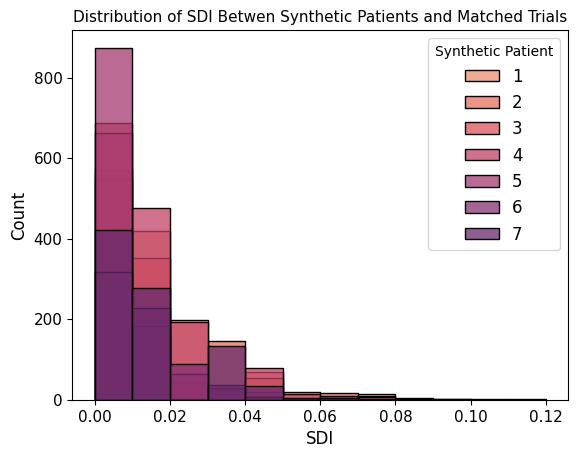

In [71]:
# List of your dataframes
dfs = [final_df, final_df_10, final_df_20, final_df_30, final_df_35, final_df_40, final_df_49]

# Pair dataframes with their respective labels
df_labels = [
    (final_df, "1"),
    (final_df_10, "2"),
    (final_df_20, "3"),
    (final_df_30, "4"),
    (final_df_35, "5"),
    (final_df_40, "6"),
    (final_df_49, "7")
]
# Get colors from a palette. Here, I use 'husl', but you can choose any available palette
colors = sns.color_palette('flare', len(df_labels))

# Plot each dataframe with its assigned color
for (df, label), color in zip(df_labels, colors):
  sns.histplot(data=df, x='SDI', color=color, binwidth=0.01, label=label)

# Display the legend
plt.legend(title="Synthetic Patient", fontsize=12)
plt.title('Distribution of SDI Betwen Synthetic Patients and Matched Trials', fontsize=11)
plt.xlabel("SDI", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

In [ ]:
pd.set_option("display.max_columns", 15)
recruiting_trials_df.iloc[:, : 12]

In [ ]:
context = model.get_pipe("medspacy_context")

for rule in context.rules[:10]:
    print()
    print(rule)

In [ ]:
exploded['semantic_mapping_ec'].value_counts()

In [ ]:
final_df

In [ ]:
final_patient_df,patient_ner_df,recruiting_trials_df,final_df = cts_parser(patients_df,model)
patient_ner_df

In [ ]:
final_df['SDI'].max()

In [ ]:
patient_gender = patient_ner_df.loc[patient_ner_df['aspects'] == 'gender', 'Patient_Profile'].values[0]
patient_age

In [ ]:
patient_bday = patient_ner_df.loc[patient_ner_df['aspects'] == 'birthday', 'Patient_Profile'].values[0]
birth_date = datetime.datetime.strptime(patient_bday, '%Y-%m-%d').date()
today = datetime.date.today()
patient_age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
patient_age

In [ ]:
pd.set_option("display.max_columns", 25)
final_df

In [ ]:
final_df.columns

In [ ]:
pd.set_option('display.max_rows', 7)
fdf2 = final_df[['NCTId','BriefTitle','Condition','EligibilityCriteria','inclusion_criteria','exclusion_criteria', 'semantic_mapping_ic', 'text_ic','umls_id_ic', 'semantic_mapping_ec', 'text_ec','umls_id_ec','SDI']]
fdf2

In [ ]:
# Choose a specific trial by its NCT ID
nct_id = fdf2['NCTId'][7]
trial = fdf2[fdf2['NCTId'] == nct_id]

# Split the eligibility criteria into inclusion and exclusion criteria
criteria = trial['text_ec'].iloc[0]
criteria

In [ ]:
fdf = final_df[['NCTId','BriefTitle','Condition','EligibilityCriteria','text_ic','semantic_mapping_ic','SDI']]
fdf

In [ ]:
fdf['EligibilityCriteria'][2532]

In [ ]:
# select the second row as a DataFrame
row_n = fdf.iloc[2532:2533]
row_n

In [ ]:
row_n['text_ic'][2532]

In [ ]:
row_n['semantic_mapping_ic'][2532]

In [ ]:
row_n['SDI'][2532]

In [ ]:
final_df['SDI'].max()

In [ ]:
pd.set_option("display.max_rows", 100)
patient_ner_df

In [ ]:
pdf_red = patient_ner_df[['aspects','Patient_Profile','text_to_parse','label_pat','semantic_mapping_pat','text_pat']]
pdf_red[60:90]

In [ ]:
patient_ner_df.to_csv('parsed_patient_ehr.csv', index=False)
recruiting_trials_df.to_csv('recruiting_clinical_trials.csv', index=False)
final_df.to_csv('parsed_clinical_trials.csv', index=False)

In [ ]:
 # Process the text using the nlp model
nlp = spacy.load("en_ner_bc5cdr_md")
nlp.add_pipe("scispacy_linker", config={"linker_name": "umls", "max_entities_per_mention": 1})
linker_bc5cdr = nlp.get_pipe("scispacy_linker")

In [ ]:
def get_semantic_types(cui, api_key):
    base_url = "https://uts-ws.nlm.nih.gov/rest"

    # Get the service ticket granting ticket (TGT)
    auth_endpoint = "https://utslogin.nlm.nih.gov/cas/v1/tickets"
    auth_data = {"apikey": api_key}
    response = requests.post(auth_endpoint, data=auth_data)
    response.raise_for_status()
    tgt = response.headers["location"]

    # Get the service ticket
    service_ticket_endpoint = f"{tgt}"
    service_ticket_data = {"service": "http://umlsks.nlm.nih.gov"}
    response = requests.post(service_ticket_endpoint, data=service_ticket_data)
    response.raise_for_status()
    service_ticket = response.text

    # Get the semantic types
    url = f"{base_url}/content/current/CUI/{cui}?ticket={service_ticket}"
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()

    # Extract semantic type names
    semantic_types = [info["name"] for info in data["result"]["semanticTypes"]]
    return semantic_types

def process_text(text: str, api_key):
    # Process the text using the nlp models
    doc_bc5cdr = nlp(text)

    # Extract entities, semantic mapping, and UMLS codes
    results = []
    for doc, linker in [(doc_bc5cdr, linker_bc5cdr)]:
        for ent in doc.ents:
            umls_mappings = ent._.kb_ents
            if umls_mappings:
                umls_code = umls_mappings[0][0]
                umls_entity = linker.kb.cui_to_entity[umls_code]
                semantic_types = get_semantic_types(umls_code, api_key)
                results.append((ent.text, semantic_types, umls_code))

    # Extract numerical quantities (age and dosage)
    age_pattern = re.compile(r'(\d+)\s?(?:year|yr|Y)?[ \-]?old', re.IGNORECASE)
    dosage_pattern = re.compile(r'(\d+(?:\.\d+)?)\s?(mg|g|mcg|ml|l|units|unit|u|i\.?u\.?)', re.IGNORECASE)

    age_matches = age_pattern.findall(text)
    dosage_matches = dosage_pattern.findall(text)

    # Append age and dosage information to the results
    for match in age_matches:
        results.append((f"{match} years old", "Age", None))

    for match in dosage_matches:
        quantity, unit = match
        results.append((f"{quantity} {unit}", "Dosage", None))

    return results

api_key = '7eaeb202-9f78-47b2-b276-5081d0845752'

text = "A 45-year-old male patient presented with a 3-day history of fever, cough, and shortness of breath. He has a past medical history of type 2 diabetes and hypertension. \
Physical examination revealed bilateral crackles on lung auscultation. A chest X-ray showed bilateral infiltrates suggestive of pneumonia. The patient was prescribed azithromycin 500 mg once daily \
and ceftriaxone 1 g intravenously for community-acquired pneumonia, and his blood glucose was managed with metformin 1000 mg twice daily. The patient was advised to follow up in one week."

entities = process_text(text, api_key)

for entity in entities:
    print(f"Entity: {entity[0]}, Type: {entity[1]}, UMLS Code: {entity[2]}")

In [ ]:
model.pipe_names

In [ ]:
person_pattern = [{'POS': 'PROPN', 'OP': '+'}, {'POS': 'PROPN', 'OP': '?'}, {'POS': 'PROPN'}]
location_pattern = [{'POS': 'PROPN'}, {'POS': 'ADP', 'OP': '?'}, {'POS': 'PROPN'}, {'POS': 'NOUN', 'OP': '?'}]
organization_pattern = [{'POS': 'PROPN'}, {'POS': 'NOUN', 'OP': '+'}]

In [ ]:
from spacy import displacy
# Load the language model
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Define the lexicon
lexicon = {'cities': ['New York', 'Los Angeles', 'Chicago', ...],
           'countries': ['USA', 'Canada', 'Mexico', ...],
           'persons': ['John Smith', 'Mary Jones', 'Tom Lee', ...]}

# Define a function to perform NER using the lexicon
def lexicon_ner(text):
    doc = nlp(text)
    entities = []
    for token in doc:
        for entity_type, entity_list in lexicon.items():
            if token.text in entity_list:
                entities.append((token.text, entity_type))
                break
    return entities

# Test the function
text = "John Smith is from New York and works for IBM."
entities = lexicon_ner(text)
print(entities)

# Display the named entities using displacy
doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

#for token in doc:
#    print(token.text, token.pos_, token.tag_, token.dep_, token.head.text)

In [ ]:
# Load the dataset
data = [
    ("John Smith is the CEO of IBM and lives in New York City.", [
        ("John Smith", "PERSON"),
        ("IBM", "ORG"),
        ("New York City", "LOC")
    ])
]

In [ ]:
from sklearn.cluster import KMeans

# Load the English language model and add the NEL component
nlp = spacy.load('en_core_web_sm')
nel = nlp.add_pipe('entity_linker')

# Define the texts to analyze
texts = [
    "Apple is a technology company that produces iPhones and Macbooks.",
    "Microsoft is a software company that produces Windows and Office.",
    "Tesla is a car company that produces electric cars and solar panels."
]

# Analyze the texts with the NEL component and extract the named entities
entities = []
for text in texts:
    doc = nlp(text)
    for ent in doc.ents:
        if ent._.kb_id is not None:
            entities.append((ent.text, ent._.kb_id))

# Cluster the entities based on their semantic mappings
mappings = {}
for entity in entities:
    kb_id = entity[1]
    if kb_id.startswith("Q"):
        concept = kb_id.split(":")[1]
        mappings.setdefault(concept, []).append(entity[0])

kmeans = KMeans(n_clusters=3)
X = [[len(mappings[concept])] for concept in mappings]
labels = kmeans.fit_predict(X)

# Print out the entity clusters
for i, concept in enumerate(mappings):
    print(f"Cluster {labels[i]}: {mappings[concept]}")

In [ ]:
def get_clinical_trials2(condition):
    """
    Creates a pandas dataframe from a query to clinicaltrials.gov

    Args:
    - condition: string representing the condition to search for

    Returns:
    - pandas dataframe with clinical trial data
    """
    # Check that condition is only 1 word else concatenate the string with a + sign
    multiword_condition = contains_multiple_words(condition)
    if multiword_condition:
        condition = "+".join(condition.split())

    url = f'https://clinicaltrials.gov/api/query/study_fields?expr={condition}&fields=NCTId,BriefTitle,Condition,OverallStatus,MinimumAge,MaximumAge,Gender,StudyPopulation,EligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv'

    # Send the API request and handle errors
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f'Request failed with status code {response.status_code}')

    # Create a pandas DataFrame from the response
    trials_df = pd.read_csv(url, skiprows=10)

    return trials_df

# Query clinical trials for lung cancer
trials_df = get_clinical_trials2('lung cancer')

In [ ]:
trials_df

In [ ]:
# split eligibility criteria into inclusion and exclusion criteria
inclusion_criteria = []
exclusion_criteria = []
for criteria in trials_df['EligibilityCriteria']:
    if pd.notna(criteria):
        split_criteria = criteria.split('Exclusion Criteria:')
        if len(split_criteria) > 1:
            inclusion_criteria.append(split_criteria[0])
            exclusion_criteria.append(split_criteria[1])
        else:
            inclusion_criteria.append(split_criteria[0])
            exclusion_criteria.append('')

# create dataframes for inclusion and exclusion criteria
inclusion_df = pd.DataFrame({'NCTId': trials_df['NCTId'], 'InclusionCriteria': inclusion_criteria})
exclusion_df = pd.DataFrame({'NCTId': trials_df['NCTId'], 'ExclusionCriteria': exclusion_criteria})

# merge dataframes
merged_df = pd.merge(trials_df, inclusion_df, on='NCTId', how='left')
merged_df = pd.merge(merged_df, exclusion_df, on='NCTId', how='left')

# split inclusion and exclusion criteria into lists of criteria
merged_df['InclusionCriteria'] = merged_df['InclusionCriteria'].apply(lambda x: x.split('|') if pd.notna(x) else [])
merged_df['ExclusionCriteria'] = merged_df['ExclusionCriteria'].apply(lambda x: x.split('|') if pd.notna(x) else [])

# create dataframes for individual inclusion and exclusion criteria
inclusion_criteria_df = merged_df.explode('InclusionCriteria')
inclusion_criteria_df = inclusion_criteria_df[['NCTId', 'InclusionCriteria']]
inclusion_criteria_df = inclusion_criteria_df[inclusion_criteria_df['InclusionCriteria'] != '']

exclusion_criteria_df = merged_df.explode('ExclusionCriteria')
exclusion_criteria_df = exclusion_criteria_df[['NCTId', 'ExclusionCriteria']]
exclusion_criteria_df = exclusion_criteria_df[exclusion_criteria_df['ExclusionCriteria'] != '']

inclusion_criteria_df

In [ ]:
exclusion_df

In [ ]:
# Choose a specific trial by its NCT ID
nct_id = trials_df['NCTId'][995]
trial = trials_df[trials_df['NCTId'] == nct_id]

# Split the eligibility criteria into inclusion and exclusion criteria
criteria = trial['EligibilityCriteria'].iloc[0]

# Split the eligibility criteria into inclusion and exclusion criteria
split_criteria = criteria.split('Exclusion criteria:')
inclusion_criteria = split_criteria[0].replace('Inclusion criteria:||', '').split('|')
inclusion_criteria = [criterion for criterion in inclusion_criteria if criterion != '']
if len(split_criteria) > 1:
    exclusion_criteria = split_criteria[1].replace('||', '').split('|')
    exclusion_criteria = [criterion for criterion in exclusion_criteria if criterion != '']

print("Inclusion criteria:")
for criterion in inclusion_criteria:
    print("- " + criterion)

print("\nExclusion criteria:")
for criterion in exclusion_criteria:
    print("- " + criterion)

In [ ]:
inclusion_df = pd.DataFrame(inclusion_criteria, columns=['InclusionCriteria'])
exclusion_df = pd.DataFrame(exclusion_criteria, columns=['ExclusionCriteria'])
inclusion_df

In [ ]:
exclusion_df

In [ ]:
nlp = spacy.load("en_core_sci_sm")
nlp.pipe_names

In [ ]:
# Choose a specific trial by its NCT ID
nct_id = trials_df['NCTId'][998]
trial = trials_df[trials_df['NCTId'] == nct_id]

# Split the eligibility criteria into inclusion and exclusion criteria
criteria = trial['EligibilityCriteria'].iloc[0]

# Split the eligibility criteria into inclusion and exclusion criteria
inclusion_criteria = criteria.split('Inclusion Criteria:||')[1].split('Exclusion Criteria:||')[0].strip().replace('||', '. ').replace('|', ' ')
exclusion_criteria = criteria.split('Exclusion Criteria:||')[1].strip().strip().replace('||', '. ').replace('|', ' ')

## Split the eligibility criteria into sentences using spacy sentence tokenizer
doc = nlp(inclusion_criteria)
i_sentences = list(doc.sents)

doc = nlp(exclusion_criteria)
e_sentences = list(doc.sents)

#Create pandas dataframe for the IC/EC such that every row is a criteria
idf = pd.DataFrame({'Inclusion_Criteria': [sentence.text for sentence in i_sentences]})#, columns=['Eligibility Criteria'])
edf = pd.DataFrame({'Exclusion_Criteria': [sentence.text for sentence in e_sentences]})

idf

In [ ]:
edf

In [ ]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz

In [ ]:
import scispacy
import spacy
import re
import en_core_sci_sm

def extract_patient_info_scispacy(profile):
    nlp = en_core_sci_sm.load()
    doc = nlp(profile)

    patient = {}

    # Extracting age using regex since NER is not very effective for it
    age = re.search("(\d+)-year-old", profile)
    patient["age"] = int(age.group(1)) if age else None

    for ent in doc.ents:
        if ent.label_ in ['DISEASE', 'CANCER']:
            patient["diagnosis"] = "lung cancer" in ent.text.lower()
        elif "fdg-pet" in ent.text.lower():
            patient["scheduled_for_FDG-PET"] = True
        elif "performance status" in ent.text.lower():
            patient["performance_status"] = int(re.search("(\d)", ent.text).group(1))
        elif "pregnant" in ent.text.lower() or "lactating" in ent.text.lower():
            patient["pregnant_or_lactating"] = True
        elif "malignant pleural effusion" in ent.text.lower():
            patient["malignant_pleural_effusion_only"] = True
        elif "irradiation" in ent.text.lower():
            patient["undergoing_irradiation"] = True
        elif "infections" in ent.text.lower():
            patient["active_infection"] = True
        elif "neurological" in ent.text.lower() or "psychiatric disorders" in ent.text.lower():
            patient["neurological_or_psychiatric_disorders"] = True
        elif "informed consent" in ent.text.lower():
            patient["consent"] = True

    # Assume False if the keys not found
    for key in ["diagnosis", "scheduled_for_FDG-PET", "performance_status", "pregnant_or_lactating", "malignant_pleural_effusion_only", "undergoing_irradiation", "active_infection", "neurological_or_psychiatric_disorders", "consent"]:
        if key not in patient:
            patient[key] = False

    return patient

In [ ]:
patient_profile = "John Doe is a 65-year-old male who has been diagnosed with lung cancer. His diagnosis was confirmed through histological examination. \
He has a ground-glass opacity (GGO) on his chest CT scan and is scheduled for biopsy and FDG-PET examination. He is not pregnant or lactating, and he does not only have malignant pleural effusion. \
He is not undergoing irradiation and has no active infections or serious underlying medical conditions. He has no history of significant neurological or psychiatric disorders. \
He and his family have provided informed consent for treatments and procedures. His performance status is 1."
# Test with a patient profile
print(extract_patient_info_scispacy(patient_profile))

In [ ]:
eligibility_criteria = """
Inclusion Criteria:
    Age > 20 years
    Informed consent obtained from patients and families
    Patients with histology confirmed lung cancer or patients with GGO on chest CT planned to have biopsy or surgery
    Patients scheduled to undergo FDG-PET examination
    Performance status: 0, 1, 2, 3

Exclusion Criteria:
    Contraindication to FAPI-PET and FDG-PET such as pregnant, or lactating patients
    Patients with mainly malignant pleural effusion without other measurable lesions
    Undergoing irradiation at accrual
    Active infection or other serious underlying medical conditions not compatible with study entry
    History of significant neurological or psychiatric disorders including dementia that would prohibit the understanding and giving of informed consent
"""

def extract_eligibility_criteria_scispacy(criteria):
    nlp = en_core_sci_sm.load()
    lines = criteria.split("\n")

    eligibility = {"inclusion": [], "exclusion": []}
    current_section = None

    for line in lines:
        doc = nlp(line.strip())
        if "inclusion criteria" in doc.text.lower():
            current_section = "inclusion"
            continue
        elif "exclusion criteria" in doc.text.lower():
            current_section = "exclusion"
            continue

        if current_section and doc.text.strip():
            eligibility[current_section].append(doc.text.strip())

    return eligibility

# Test with eligibility criteria
eligibility = extract_eligibility_criteria_scispacy(eligibility_criteria)
eligibility

In [ ]:
eligibility['inclusion']

In [ ]:
eligibility['exclusion']

In [ ]:
def generate_criteria_profile(criteria_dict):
    nlp = en_core_sci_sm.load()

    profile = {"inclusion": {}, "exclusion": {}}

    for category in ['inclusion', 'exclusion']:
        for criterion in criteria_dict[category]:
            doc = nlp(criterion)
            if "age" in doc.text.lower():
                match = re.search("age\s*>\s*(\d+)", doc.text.lower())
                if match:
                    profile[category]["min_age"] = int(match.group(1))
            if "informed consent" in doc.text.lower():
                profile[category]["consent_required"] = True
            if "lung cancer" in doc.text.lower() or "ggo" in doc.text.lower():
                profile[category]["lung_cancer_or_GGO_required"] = True
            if "fdg-pet" in doc.text.lower():
                profile[category]["FDG-PET_required"] = True
            if "performance status" in doc.text.lower():
                match = re.findall("(\d)", doc.text.lower())
                if match:
                    profile[category]["performance_status"] = list(map(int, match))
            if "pregnant" in doc.text.lower() or "lactating" in doc.text.lower():
                profile[category]["pregnant_or_lactating"] = True
            if "malignant pleural effusion" in doc.text.lower():
                profile[category]["malignant_pleural_effusion_only"] = True
            if "irradiation" in doc.text.lower():
                profile[category]["undergoing_irradiation"] = True
            if "infections" in doc.text.lower():
                profile[category]["active_infection"] = True
            if "neurological" in doc.text.lower() or "psychiatric disorders" in doc.text.lower():
                profile[category]["neurological_or_psychiatric_disorders"] = True

    return profile

ct_profile = generate_criteria_profile(eligibility)
ct_profile